This notebook aims to fit a binary classifier that predicts participant's group, AVGP or NVGP, using Cognitive Control network connectivity matrices.


In [36]:
import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection
from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier  # incompatible with umap's scipy

sns.set(style='dark')

from umap import UMAP

In [4]:
# 1. load the connectivity dataset
DATASET = xr.open_dataset('data/julia2018_resting/connectivities.nc').load()

In [19]:
# 1. input (connectivities)
X = np.array(
  [subj_conn[np.triu_indices_from(subj_conn, k=1)] 
   for subj_conn in DATASET['connectivity'].values]
  )

# 2. classifier output (AVGP or NVGP)
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(DATASET['group'])

# 3. behavioral outputs (inverse efficiency scores in millis)
y_beh = DATASET['inverse_efficiency_score_ms'].values

# 4. remove subjects with missing connectivity and behavioral data
valid_subjects_mask = ~np.isnan(y_beh)
X = X[valid_subjects_mask]
y = y[valid_subjects_mask]
y_beh = y_beh[valid_subjects_mask]

# 4. Feature extraction
# X_thresholds = np.median(X, axis=1) + np.std(X, axis=1)
# X_binarized = np.where(np.abs(X) < X_thresholds.reshape(-1,1), 0., 1.)
# X_reduced = UMAP(n_neighbors=15, n_components=2).fit_transform(X)

In [21]:
# 3. test/train split
X_train, X_test, y_train, y_test = model_selection.train_test_split(
  X, y,
  test_size=0.2, shuffle=True, stratify=y,
  # random_state=42,
  )

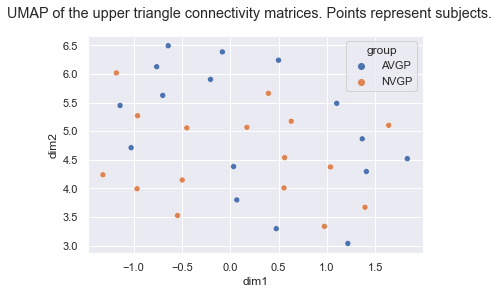

In [28]:
# DEBUG: plot dimensionality-reduced inputs, colored by outputs

# X_reduced = feature_selection.SelectKBest(k=10).fit_transform(X, y)
X_reduced = UMAP(n_neighbors=15, n_components=2).fit_transform(X, y_beh)
X_reduced = pd.DataFrame(X_reduced, columns=['dim1','dim2'])
X_reduced['group'] = y_encoder.inverse_transform(y)

sns.scatterplot(x='dim1', y='dim2', hue='group', data=X_reduced)
plt.suptitle('UMAP of the upper triangle connectivity matrices. Points represent subjects.')
plt.show()

In [29]:
model = ensemble.GradientBoostingClassifier()
# model = multioutput.MultiOutputClassifier(ensemble.GradientBoostingClassifier())

pipeline = Pipeline([
    ('zerovar', feature_selection.VarianceThreshold()),
    # ('select', feature_selection.SelectKBest()),
    # ('standard_scaler', preprocessing.StandardScaler()), 
    ('reducer', UMAP(n_components=2)), 
    # ('reducer', decomposition.PCA()),
    # ('reducer', cross_decomposition.PLSCanonical()),    
    ('model', model)
])

param_grid = {
    'zerovar__threshold': [0],
    # 'select__k': np.linspace(1, X.shape[1], 10, dtype='int'),
    # 'reducer__n_neighbors': [1, 2, 3, 4, 5, 10],       # UMAP
    # 'reducer__n_components': [2],                        # UMAP
    # 'reducer__n_components': range(1,21),              # PCA
    'model__n_estimators': [100],         # XGBClassifier, GradientBoostingClassifier
    # 'model__estimator__n_estimators': [10, 100],       # MultiOutputClassifier
}

grid = model_selection.GridSearchCV(
    pipeline, param_grid, cv=5,
    scoring='accuracy',
    # scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'], refit='accuracy',
    n_jobs=1, verbose=3
)

# DEBUG
# pipeline.fit(X_train, y_train)
# score = pipeline.score(X_test, y_test)

grid.fit(X_train, y_train)
score = grid.score(X_test, y_test)

# report scores
clear_output(wait=True)

print(f'Test set score (accuracy): {score:.2f}')

Test set score (accuracy): 0.86


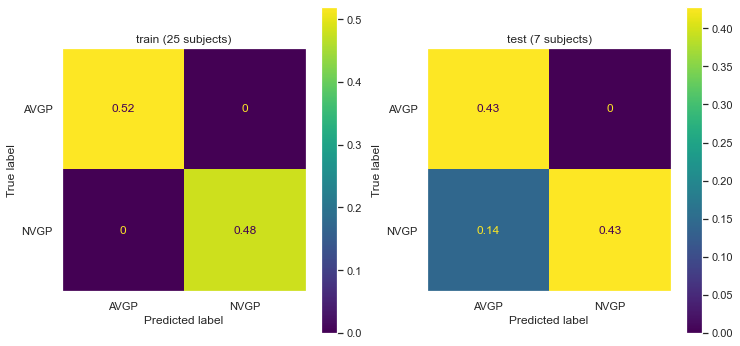

In [35]:
# plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# train set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X_train, y_train,
  normalize='all',
  display_labels=y_encoder.classes_,
  ax=axes[0],
  )

# test set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X_test, y_test,
  normalize='all',
  display_labels=y_encoder.classes_,
  ax=axes[1],
  )

# set titles
axes[0].set(title=f'train ({len(y_train)} subjects)')
axes[1].set(title=f'test ({len(y_test)} subjects)')

plt.show()

In [ ]:
%reload_ext watermark
%watermark -iv -co -ituhmv